# This notebook checks the assumptions of the 6 data simulations.

### For each simulation, looks at sample 1
### For each sample, looks at 5 randomly chosen features (of the 20 generated).
### Results are for datasets with training set size of 300,000 and test set size of 100,000.

#### Alene Rhea, May 10, 2021

In [1]:
import pandas as pd
import pathlib, os, pickle
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import random

In [2]:
base_repo_dir = pathlib.Path(os.getcwd())

# Set random state
random.seed(42)

# Set number of samples and number of features to test
n_samps = 2
n_xfeats = 5

# Look specifically at sample 1 rather then randomly choosing
# (Implemented this way bc only have these samples saved on local)
samps = [1]

# Function to get estimated y0 and y1 
# when real (non-noisey) y0/y1 not exported
def get_potential_outcomes(df):
    
    # Initialize y0 and y1
    df['y0'] = np.nan
    df['y1'] = np.nan
    
    # Get observed outcomes
    df.loc[df.treatment==0, 'y0'] = df.loc[df.treatment==0, 'Y']
    df.loc[df.treatment==1, 'y1'] = df.loc[df.treatment==1, 'Y']
    
    # Get unobserved outcomes
    df.loc[df.treatment==0, 'y1'] = df.loc[df.treatment==0, 'y0'] + df.loc[df.treatment==0, 'tau']
    df.loc[df.treatment==1, 'y0'] = df.loc[df.treatment==1, 'y1'] - df.loc[df.treatment==1, 'tau']
    
    return df

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Sim A


Testing Sample 1 of Simulation A
Visually check that x4, x1, x9, x8, and x17 are approximately normal...


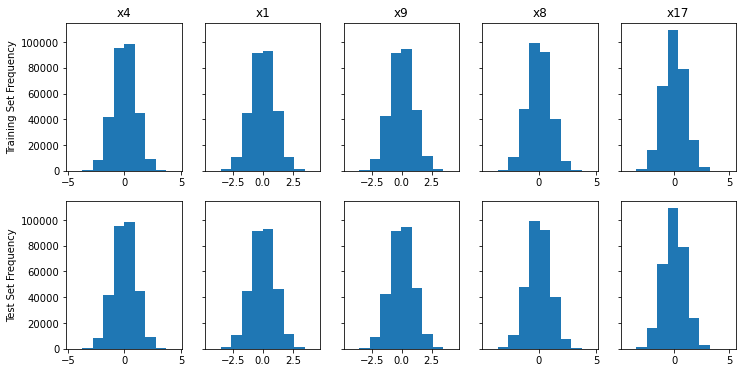

All propensity scores are 0.01? True
Proportion of training set with treatment=1 (should be close to 0.01):  0.0099
Proportion of test set with treatment=1 (should be close to 0.01):  0.01
For training set, E[Y0 | x1 > 0.5 ] - E[Y0 | x1 <= 0.5 ] (should be about 5):  1.0405
For test set, E[Y0 | x1 > 0.5 ] - E[Y0 | x1 <= 0.5 ] (should be about 5):  8.059
Wherever x2>0.1, tau=8?  True
Wherever x2<=0.1, tau=0?  True


In [4]:
# Choose 2 samples of simA to test
#Asamps = random.sample(list(np.arange(1,31,1)), n_samps)

for samp in samps:
    print('\nTesting Sample {} of Simulation A'.format(samp))
    
    # Read in test and train
    tr = pd.read_parquet(base_repo_dir / 'data' / 'simA' / 'samp{}_train.parquet'.format(samp))
    te = pd.read_parquet(base_repo_dir / 'data' / 'simA' / 'samp{}_test.parquet'.format(samp))
    
    # Read in extra columns
    tr_extra = pd.read_parquet(base_repo_dir / 'data' / 'simA' / 'samp{}_train_extra.parquet'.format(samp))
    te_extra = pd.read_parquet(base_repo_dir / 'data' / 'simA' / 'samp{}_test_extra.parquet'.format(samp))
    
    # Concatenate extra cols with regular cols
    tr = pd.concat([tr, tr_extra], axis=1)
    te = pd.concat([te, te_extra], axis=1)

    #Choose 5 X features to test
    xfeats = random.sample(list(np.arange(1,21,1)), n_xfeats)
    print('Visually check that x{}, x{}, x{}, x{}, and x{} are approximately normal...'.format(*xfeats))
    
    fig, ax = plt.subplots(2,n_xfeats, figsize=(12,6), sharey=True)
    for i, x in enumerate(xfeats):
        ax[0][i].hist(tr['x'+str(x)])
        ax[1][i].hist(tr['x'+str(x)])
        ax[0][i].set_title('x'+str(x))
    ax[0][0].set_ylabel('Training Set Frequency')
    ax[1][0].set_ylabel('Test Set Frequency')
    plt.show()
    
    print('All propensity scores are 0.01?', (all(tr.pscore==.01)&all(te.pscore==.01)))
    print('Proportion of training set with treatment=1 (should be close to 0.01): ', 
          round(sum(tr.treatment==1)/len(tr), 4))
    print('Proportion of test set with treatment=1 (should be close to 0.01): ', 
          round(sum(te.treatment==1)/len(te), 4))
    
    print('For training set, E[Y0 | x1 > 0.5 ] - E[Y0 | x1 <= 0.5 ] (should be about 5): ',
          round(np.mean(tr[tr.x1>0.5]['Y0']) - np.mean(tr[tr.x1<=0.5]['Y0']), 4))
    
    print('For test set, E[Y0 | x1 > 0.5 ] - E[Y0 | x1 <= 0.5 ] (should be about 5): ',
          round(np.mean(te[te.x1>0.5]['Y0']) - np.mean(te[te.x1<=0.5]['Y0']), 4))
    
    print('Wherever x2>0.1, tau=8? ', all(np.isclose(tr[tr.x2>0.1]['tau'],8)) \
                                    & all(np.isclose(te[te.x2>0.1]['tau'],8)))
    print('Wherever x2<=0.1, tau=0? ', all(np.isclose(tr[tr.x2<=0.1]['tau'],0)) \
                                    & all(np.isclose(te[te.x2<=0.1]['tau'],0)))
    

#### Difference in Mean y0 (conditioned on x1) is questionable. Distance from 5 likely due to the fact that we have not accounted for the effect that x1 being greater or smaller than 0.5 will have on $x^T\beta$. Expectation of 5 should hold across samples of beta. We see (weak) evidence of this if we average what we see in train and what we see in test. All other checks passed. 

## Sim B


Testing Sample 1 of Simulation B
Visually check that x5, x4, x18, x3, and x14 are approximately normal...


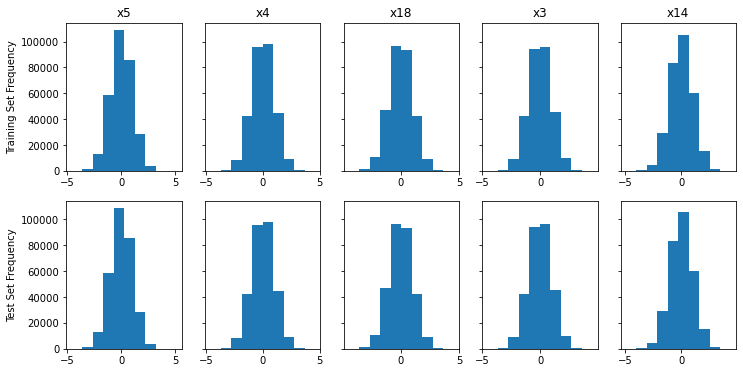

All propensity scores are 0.5? True
Proportion of training set with treatment=1 (should be close to 0.5):  0.5015
Proportion of test set with treatment=1 (should be close to 0.5):  0.4999


In [5]:
# Choose 2 samples of simB to test
# Bsamps = random.sample(list(np.arange(1,31,1)), n_samps)

for samp in samps:
    print('\nTesting Sample {} of Simulation B'.format(samp))
    
    # Read in test and train
    tr = pd.read_parquet(base_repo_dir / 'data' / 'simB' / 'samp{}_train.parquet'.format(samp))
    te = pd.read_parquet(base_repo_dir / 'data' / 'simB' / 'samp{}_test.parquet'.format(samp))
    
    # Read in extra columns
    tr_extra = pd.read_parquet(base_repo_dir / 'data' / 'simB' / 'samp{}_train_extra.parquet'.format(samp))
    te_extra = pd.read_parquet(base_repo_dir / 'data' / 'simB' / 'samp{}_test_extra.parquet'.format(samp))
    
    # Concatenate extra cols with regular cols
    tr = pd.concat([tr, tr_extra], axis=1)
    te = pd.concat([te, te_extra], axis=1)

    #Choose 5 X features to test
    xfeats = random.sample(list(np.arange(1,21,1)), n_xfeats)
    print('Visually check that x{}, x{}, x{}, x{}, and x{} are approximately normal...'.format(*xfeats))
    
    fig, ax = plt.subplots(2,n_xfeats, figsize=(12,6), sharey=True)
    for i, x in enumerate(xfeats):
        ax[0][i].hist(tr['x'+str(x)])
        ax[1][i].hist(tr['x'+str(x)])
        ax[0][i].set_title('x'+str(x))
    ax[0][0].set_ylabel('Training Set Frequency')
    ax[1][0].set_ylabel('Test Set Frequency')
    plt.show()
    
    print('All propensity scores are 0.5?', (all(tr.pscore==.5)&all(te.pscore==.5)))
    print('Proportion of training set with treatment=1 (should be close to 0.5): ', 
          round(sum(tr.treatment==1)/len(tr), 4))
    print('Proportion of test set with treatment=1 (should be close to 0.5): ', 
          round(sum(te.treatment==1)/len(te), 4))


#### All checks passed.

## Sim C


Testing Sample 1 of Simulation C
Visually check that x2, x1, x3, x7, and x8 are approximately normal...


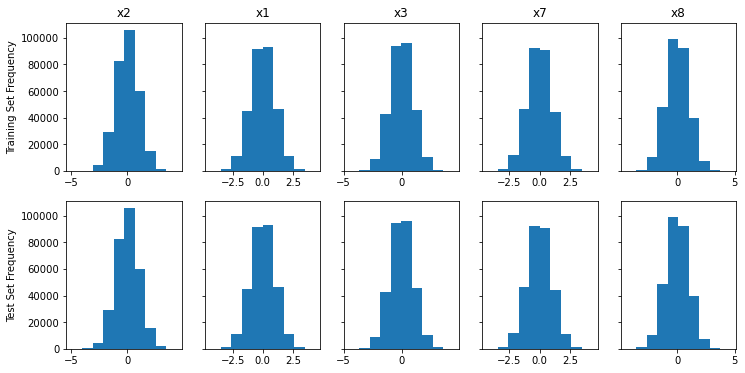

All propensity scores are 0.5? True
Proportion of training set with treatment=1 (should be close to 0.5):  0.5015
Proportion of test set with treatment=1 (should be close to 0.5):  0.4999
Trainig set Y0 is product of transformed x1 and x2? True
Test set Y0 is product of transformed x1 and x2? True
Trainig set Y1 is product of transformed x1 and x2? True
Test set Y1 is product of transformed x1 and x2? True


In [6]:
# Choose 2 samples of simC to test
# Csamps = random.sample(list(np.arange(1,31,1)), n_samps)

# Complex non-linear transformation function from SI 3
def simC_transform(x):
    x = x.values
    return 2/( 1 + np.exp(-12*(x - 0.5)))

for samp in samps:
    print('\nTesting Sample {} of Simulation C'.format(samp))
    
    # Read in test and train
    tr = pd.read_parquet(base_repo_dir / 'data' / 'simC' / 'samp{}_train.parquet'.format(samp))
    te = pd.read_parquet(base_repo_dir / 'data' / 'simC' / 'samp{}_test.parquet'.format(samp))
    
    # Read in extra columns
    tr_extra = pd.read_parquet(base_repo_dir / 'data' / 'simC' / 'samp{}_train_extra.parquet'.format(samp))
    te_extra = pd.read_parquet(base_repo_dir / 'data' / 'simC' / 'samp{}_test_extra.parquet'.format(samp))
    
    # Concatenate extra cols with regular cols
    tr = pd.concat([tr, tr_extra], axis=1)
    te = pd.concat([te, te_extra], axis=1)

    #Choose 5 X features to test
    xfeats = random.sample(list(np.arange(1,21,1)), n_xfeats)
    print('Visually check that x{}, x{}, x{}, x{}, and x{} are approximately normal...'.format(*xfeats))
    
    fig, ax = plt.subplots(2,n_xfeats, figsize=(12,6), sharey=True)
    for i, x in enumerate(xfeats):
        ax[0][i].hist(tr['x'+str(x)])
        ax[1][i].hist(tr['x'+str(x)])
        ax[0][i].set_title('x'+str(x))
    ax[0][0].set_ylabel('Training Set Frequency')
    ax[1][0].set_ylabel('Test Set Frequency')
    plt.show()
    
    print('All propensity scores are 0.5?', (all(tr.pscore==.5)&all(te.pscore==.5)))
    print('Proportion of training set with treatment=1 (should be close to 0.5): ', 
          round(sum(tr.treatment==1)/len(tr), 4))
    print('Proportion of test set with treatment=1 (should be close to 0.5): ', 
          round(sum(te.treatment==1)/len(te), 4))
    
    print('Trainig set Y0 is product of transformed x1 and x2?', 
          all(np.isclose(tr.Y0, -0.5*simC_transform(tr.x1)*simC_transform(tr.x2))))
    print('Test set Y0 is product of transformed x1 and x2?', 
          all(np.isclose(te.Y0, -0.5*simC_transform(te.x1)*simC_transform(te.x2))))
    print('Trainig set Y1 is product of transformed x1 and x2?', 
          all(np.isclose(tr.Y1, 0.5*simC_transform(tr.x1)*simC_transform(tr.x2))))
    print('Test set Y1 is product of transformed x1 and x2?', 
          all(np.isclose(te.Y1, 0.5*simC_transform(te.x1)*simC_transform(te.x2))))


#### All checks passed.

## Sim D


Testing Sample 1 of Simulation D
Visually check that x17, x1, x18, x7, and x14 are approximately uniform...


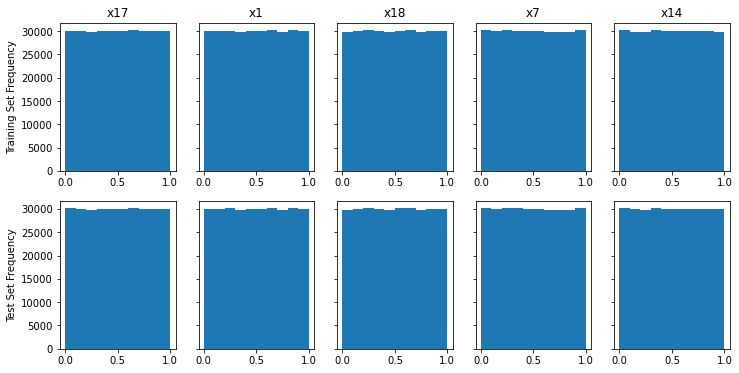

Training Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x17,x1,x18,x7,x14
x17,1.000000,0.000406,-0.003011,-0.003399,0.001511
x1,0.000406,1.000000,-0.000642,0.000656,0.000747
x18,-0.003011,-0.000642,1.000000,0.000346,0.001647
x7,-0.003399,0.000656,0.000346,1.000000,-0.003444
x14,0.001511,0.000747,0.001647,-0.003444,1.000000



Test Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x17,x1,x18,x7,x14
x17,1.000000,0.002385,-0.004161,-0.000571,-0.006918
x1,0.002385,1.000000,-0.005396,-0.003937,0.005113
x18,-0.004161,-0.005396,1.000000,-0.000507,0.001232
x7,-0.000571,-0.003937,-0.000507,1.000000,-0.007906
x14,-0.006918,0.005113,0.001232,-0.007906,1.000000



Training set propensity score correlations with X (should be close to 0 for all but x1): 


,R,p
x17,0.000971,0.594826
x1,-0.753204,0.000000
x18,0.000559,0.759635
x7,-0.001164,0.523772
x14,0.001520,0.405191



Test set propensity score correlations with X (should be close to 0 for all but x1): 


,R,p
x17,0.002608,0.409588
x1,-0.751270,0.000000
x18,-0.007167,0.023428
x7,-0.000640,0.839728
x14,-0.002878,0.362771


Y0 = 2*x1-1?  True
All tau are 0? True


In [7]:
# Choose 2 samples of simD to test
# Dsamps = random.sample(list(np.arange(1,31,1)), n_samps)

for samp in samps:
    print('\nTesting Sample {} of Simulation D'.format(samp))
    
    # Read in test and train
    tr = pd.read_parquet(base_repo_dir / 'data' / 'simD' / 'samp{}_train.parquet'.format(samp))
    te = pd.read_parquet(base_repo_dir / 'data' / 'simD' / 'samp{}_test.parquet'.format(samp))
    
    # Read in extra columns
    tr_extra = pd.read_parquet(base_repo_dir / 'data' / 'simD' / 'samp{}_train_extra.parquet'.format(samp))
    te_extra = pd.read_parquet(base_repo_dir / 'data' / 'simD' / 'samp{}_test_extra.parquet'.format(samp))
    
    # Concatenate extra cols with regular cols
    tr = pd.concat([tr, tr_extra], axis=1)
    te = pd.concat([te, te_extra], axis=1)

    #Choose 5 X features to test
    xfeats = random.sample(list(np.arange(1,21,1)), n_xfeats)
    print('Visually check that x{}, x{}, x{}, x{}, and x{} are approximately uniform...'.format(*xfeats))
    
    fig, ax = plt.subplots(2,n_xfeats, figsize=(12,6), sharey=True)
    for i, x in enumerate(xfeats):
        ax[0][i].hist(tr['x'+str(x)])
        ax[1][i].hist(tr['x'+str(x)])
        ax[0][i].set_title('x'+str(x))
    ax[0][0].set_ylabel('Training Set Frequency')
    ax[1][0].set_ylabel('Test Set Frequency')
    plt.show()
    
    feat_list = ['x'+str(x) for x in xfeats]
    
    print('Training Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)')
    display(pd.DataFrame(np.corrcoef(tr.values.T[xfeats]),
                         index = feat_list, 
                         columns = feat_list))
    
    print('\nTest Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)')
    display(pd.DataFrame(np.corrcoef(te.values.T[xfeats]),
                         index = feat_list, 
                         columns = feat_list))
    
    if 'x1' in feat_list:
        long_feat_list = feat_list
    else:
        long_feat_list = ['x1'] + feat_list

    tr_p_corrs = pd.DataFrame([pearsonr(tr[x], tr['pscore']) for x in long_feat_list], 
                              columns=['R', 'p'], index=long_feat_list)

    print('\nTraining set propensity score correlations with X (should be close to 0 for all but x1): ')
    display(tr_p_corrs)
    
    te_p_corrs = pd.DataFrame([pearsonr(te[x], te['pscore']) for x in long_feat_list], 
                              columns=['R', 'p'], index=long_feat_list)

    print('\nTest set propensity score correlations with X (should be close to 0 for all but x1): ')
    display(te_p_corrs)

    
    print('Y0 = 2*x1-1? ', all(np.isclose(tr.Y0, 2*tr.x1-1)) & all(np.isclose(te.Y0, 2*te.x1-1)))
    
    print('All tau are 0?', (all(tr.tau==0)&all(te.tau==0)))


#### All checks passed.

## Sim E


Testing Sample 1 of Simulation E
Visually check that x8, x15, x9, x1, and x6 are approximately uniform...


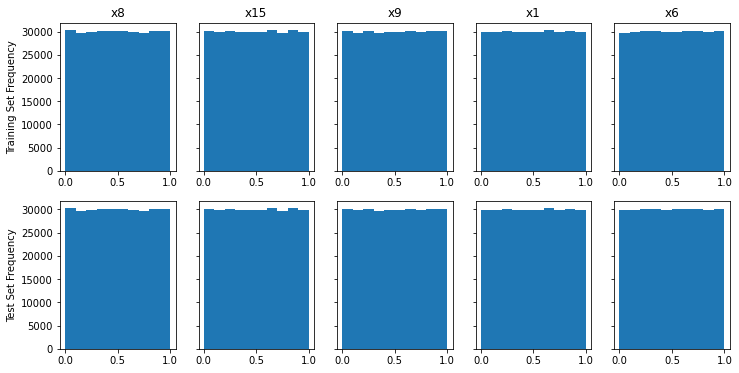

Training Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x8,x15,x9,x1,x6
x8,1.000000,0.001552,-0.001819,-0.001214,0.001057
x15,0.001552,1.000000,-0.001045,-0.000304,-0.000160
x9,-0.001819,-0.001045,1.000000,-0.000861,0.000004
x1,-0.001214,-0.000304,-0.000861,1.000000,-0.002088
x6,0.001057,-0.000160,0.000004,-0.002088,1.000000



Test Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x8,x15,x9,x1,x6
x8,1.000000,-0.000574,-0.005071,-0.001194,0.000913
x15,-0.000574,1.000000,0.003141,-0.004288,-0.003414
x9,-0.005071,0.003141,1.000000,0.001469,0.004222
x1,-0.001194,-0.004288,0.001469,1.000000,-0.000341
x6,0.000913,-0.003414,0.004222,-0.000341,1.000000



Training set propensity score correlations with X (should be close to 0 for all but x1): 


,R,p
x8,-0.003182,0.081331
x15,-0.001169,0.522041
x9,-0.001550,0.395958
x1,-0.753204,0.000000
x6,-0.000638,0.726841



Test set propensity score correlations with X (should be close to 0 for all but x1): 


,R,p
x8,-0.000090,0.977197
x15,-0.005675,0.072718
x9,0.004484,0.156236
x1,-0.751270,0.000000
x6,-0.001286,0.684161


Y0 = 2*x1-1?  True
Wherever x2>0.1, tau=8?  True
Wherever x2<=0.1, tau=0?  True


In [8]:
# Choose 2 samples of simE to test
# Esamps = random.sample(list(np.arange(1,31,1)), n_samps)

for samp in samps:
    print('\nTesting Sample {} of Simulation E'.format(samp))
    
    # Read in test and train
    tr = pd.read_parquet(base_repo_dir / 'data' / 'simE' / 'samp{}_train.parquet'.format(samp))
    te = pd.read_parquet(base_repo_dir / 'data' / 'simE' / 'samp{}_test.parquet'.format(samp))
    
    # Read in extra columns
    tr_extra = pd.read_parquet(base_repo_dir / 'data' / 'simE' / 'samp{}_train_extra.parquet'.format(samp))
    te_extra = pd.read_parquet(base_repo_dir / 'data' / 'simE' / 'samp{}_test_extra.parquet'.format(samp))
    
    # Concatenate extra cols with regular cols
    tr = pd.concat([tr, tr_extra], axis=1)
    te = pd.concat([te, te_extra], axis=1)

    #Choose 5 X features to test
    xfeats = random.sample(list(np.arange(1,21,1)), n_xfeats)
    print('Visually check that x{}, x{}, x{}, x{}, and x{} are approximately uniform...'.format(*xfeats))
    
    fig, ax = plt.subplots(2,n_xfeats, figsize=(12,6), sharey=True)
    for i, x in enumerate(xfeats):
        ax[0][i].hist(tr['x'+str(x)])
        ax[1][i].hist(tr['x'+str(x)])
        ax[0][i].set_title('x'+str(x))
    ax[0][0].set_ylabel('Training Set Frequency')
    ax[1][0].set_ylabel('Test Set Frequency')
    plt.show()
    
    feat_list = ['x'+str(x) for x in xfeats]
    
    print('Training Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)')
    display(pd.DataFrame(np.corrcoef(tr.values.T[xfeats]),
                         index = feat_list, 
                         columns = feat_list))
    
    print('\nTest Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)')
    display(pd.DataFrame(np.corrcoef(te.values.T[xfeats]),
                         index = feat_list, 
                         columns = feat_list))
    
    if 'x1' in feat_list:
        long_feat_list = feat_list
    else:
        long_feat_list = ['x1'] + feat_list

    tr_p_corrs = pd.DataFrame([pearsonr(tr[x], tr['pscore']) for x in long_feat_list], 
                              columns=['R', 'p'], index=long_feat_list)

    print('\nTraining set propensity score correlations with X (should be close to 0 for all but x1): ')
    display(tr_p_corrs)
    
    te_p_corrs = pd.DataFrame([pearsonr(te[x], te['pscore']) for x in long_feat_list], 
                              columns=['R', 'p'], index=long_feat_list)

    print('\nTest set propensity score correlations with X (should be close to 0 for all but x1): ')
    display(te_p_corrs)
    
    
    print('Y0 = 2*x1-1? ', all(np.isclose(tr.Y0, 2*tr.x1-1)) & all(np.isclose(te.Y0, 2*te.x1-1)))
    
    print('Wherever x2>0.1, tau=8? ', all(np.isclose(tr[tr.x2>0.1]['tau'],8)) \
                                    & all(np.isclose(te[te.x2>0.1]['tau'],8)))
    print('Wherever x2<=0.1, tau=0? ', all(np.isclose(tr[tr.x2<=0.1]['tau'],0)) \
                                    & all(np.isclose(te[te.x2<=0.1]['tau'],0)))


#### All checks passed.

## Sim F


Testing Sample 1 of Simulation F
Visually check that x14, x11, x9, x5, and x7 are approximately uniform...


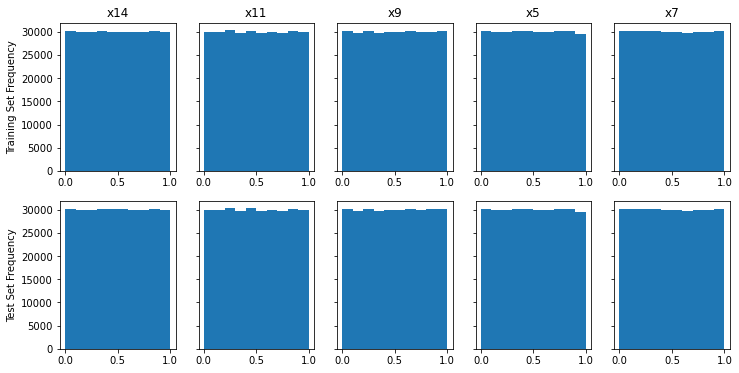

Training Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x14,x11,x9,x5,x7
x14,1.000000,-0.004675,0.001672,0.001964,-0.003444
x11,-0.004675,1.000000,0.002415,0.000440,0.001561
x9,0.001672,0.002415,1.000000,-0.000811,-0.000571
x5,0.001964,0.000440,-0.000811,1.000000,0.002120
x7,-0.003444,0.001561,-0.000571,0.002120,1.000000



Test Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)


,x14,x11,x9,x5,x7
x14,1.000000,0.010654,-0.002758,-0.004127,-0.007906
x11,0.010654,1.000000,0.002123,-0.001339,-0.001153
x9,-0.002758,0.002123,1.000000,0.007123,0.000161
x5,-0.004127,-0.001339,0.007123,1.000000,0.001007
x7,-0.007906,-0.001153,0.000161,0.001007,1.000000


Y0 = 2*x1-1?  True
Training set propensity score = max(min((confounder + 2*x1)/2, 0.95), 0.05):  True
Test set propensity score = max(min((confounder + 2*x1)/2, 0.95), 0.05):  True
Wherever x2>0.1, tau=8+2*confounder?  True
Wherever x2<=0.1, tau=2*confounder?  True


In [9]:
# Choose 2 samples of simF to test
# Fsamps = random.sample(list(np.arange(1,31,1)), n_samps)

for samp in samps:
    print('\nTesting Sample {} of Simulation F'.format(samp))
    
    # Read in test and train
    tr = pd.read_parquet(base_repo_dir / 'data' / 'simF' / 'samp{}_train.parquet'.format(samp))
    te = pd.read_parquet(base_repo_dir / 'data' / 'simF' / 'samp{}_test.parquet'.format(samp))
    
    # Read in extra columns
    tr_extra = pd.read_parquet(base_repo_dir / 'data' / 'simF' / 'samp{}_train_extra.parquet'.format(samp))
    te_extra = pd.read_parquet(base_repo_dir / 'data' / 'simF' / 'samp{}_test_extra.parquet'.format(samp))
    
    # Concatenate extra cols with regular cols
    tr = pd.concat([tr, tr_extra], axis=1)
    te = pd.concat([te, te_extra], axis=1)

    #Choose 5 X features to test
    xfeats = random.sample(list(np.arange(1,21,1)), n_xfeats)
    print('Visually check that x{}, x{}, x{}, x{}, and x{} are approximately uniform...'.format(*xfeats))
    
    fig, ax = plt.subplots(2,n_xfeats, figsize=(12,6), sharey=True)
    for i, x in enumerate(xfeats):
        ax[0][i].hist(tr['x'+str(x)])
        ax[1][i].hist(tr['x'+str(x)])
        ax[0][i].set_title('x'+str(x))
    ax[0][0].set_ylabel('Training Set Frequency')
    ax[1][0].set_ylabel('Test Set Frequency')
    plt.show()
    
    feat_list = ['x'+str(x) for x in xfeats]
    
    print('Training Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)')
    display(pd.DataFrame(np.corrcoef(tr.values.T[xfeats]),
                         index = feat_list, 
                         columns = feat_list))
    
    print('\nTest Set Feature Correlation Matrix (should be 1 along diagonal, and close to 0 elsewhere)')
    display(pd.DataFrame(np.corrcoef(te.values.T[xfeats]),
                         index = feat_list, 
                         columns = feat_list))
    
    if 'x1' in feat_list:
        long_feat_list = feat_list
    else:
        long_feat_list = ['x1'] + feat_list

    tr_p_corrs = pd.DataFrame([pearsonr(tr[x], tr['pscore']) for x in long_feat_list], 
                              columns=['R', 'p'], index=long_feat_list)

    
    print('Y0 = 2*x1-1? ', all(np.isclose(tr.Y0, 2*tr.x1-1)) & all(np.isclose(te.Y0, 2*te.x1-1)))
    
    a_tr = np.array((tr.confounder+2*tr.x1)/2)
    amin_tr = np.array([np.full(len(a_tr), 0.95), a_tr])
    amax_tr = np.array([np.full(len(a_tr), 0.05), np.min(amin_tr, axis=0)])
    print('Training set propensity score = max(min((confounder + 2*x1)/2, 0.95), 0.05): ',
            all(np.isclose(tr.pscore, np.max(amax_tr, axis=0))))
    
    a_te = np.array((te.confounder+2*te.x1)/2)
    amin_te = np.array([np.full(len(a_te), 0.95), a_te])
    amax_te = np.array([np.full(len(a_te), 0.05), np.min(amin_te, axis=0)])
    print('Test set propensity score = max(min((confounder + 2*x1)/2, 0.95), 0.05): ',
            all(np.isclose(te.pscore, np.max(amax_te, axis=0))))
    
    
    print('Wherever x2>0.1, tau=8+2*confounder? ', all(np.isclose(tr[tr.x2>0.1]['tau'],\
                                                                 8+2*tr[tr.x2>0.1]['confounder'])) \
                                                 & all(np.isclose(te[te.x2>0.1]['tau'],\
                                                                 8+2*te[te.x2>0.1]['confounder'])))
    print('Wherever x2<=0.1, tau=2*confounder? ', all(np.isclose(tr[tr.x2<=0.1]['tau'],\
                                                                 2*tr[tr.x2<=0.1]['confounder'])) \
                                                 & all(np.isclose(te[te.x2<=0.1]['tau'],\
                                                                 2*te[te.x2<=0.1]['confounder'])))


#### All checks passed.